## RAG
* Retrieval of relevant information from a document
* Augment the relevant information
* Generate a summary of the relevant information

In [1]:
!nvidia-smi

Mon Sep 30 10:29:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     Off | 00000000:01:00.0 Off |                  N/A |
|  0%   51C    P0              92W / 350W |     10MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Steps to follow
1. Open a pdf
2. Format text
3. Embed chunks of text and turn into embedding
4. Build a retrieval system
5. Generate a prompt that incorporates retrieved pieces of text
6. Generate answer

Github link format for raw files
example
https://github.com/mrdbourke/simple-local-rag/blob/main/human-nutrition-text.pdf
instead of blob replace with raw/refs/heads
https://github.com/mrdbourke/simple-local-rag/raw/refs/heads/main/human-nutrition-text.pdf

In [2]:
import os
import requests
from tqdm.auto import tqdm

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print("File not exist ")

    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    filename = pdf_path
    request = requests.get(url,
                        #    stream=True
                           )
    if request.status_code == 200:
        with open(filename, "wb") as f:
            for buffer in tqdm(request.iter_content(),total=float(request.headers['Content-Length'])):
                f.write(buffer)
        print("File downloaded")

else:
    print("File exists")

File exists


In [3]:
import fitz

def text_formatter(text:str) -> str:
    cleaned_text = text.replace("\xa0", " ")  # Handles non-breaking space
    cleaned_text = text.replace("\n", " ").strip()

    return cleaned_text

def open_and_read_pdf(pdf_path: str):
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 41,# 41 substracted as original page numbers start from page 41 in pdf
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split('.')),
                                "text": text})  
        
    
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path)
pages_and_texts[:2]


0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'text': ''}]

In [4]:
import random
random.sample(pages_and_texts, 3)

[{'page_number': 564,
  'page_char_count': 1177,
  'page_word_count': 266,
  'page_sentence_count_raw': 33,
  'text': 'factsheets/Riboflavin-HealthProfessional/. Updated February 11,  2016. Accessed October 22, 2017.  Dietary Sources  Riboflavin can be found in a variety of different foods but it is  important to remember that it can be destroyed by sunlight. \xa0Milk  is one of the best sources of riboflavin in the diet and was once  delivered and packaged in glass bottles. This packaging has changed  to cloudy plastic containers or cardboard to help block the light  from destroying the riboflavin in milk. \xa0For the riboflavin content of  various foods, see Table 9.16 Riboflavin Content of Various Foods”.  Table 9.16 Riboflavin Content of Various Foods  Food  Serving  Riboflavin  (mg)  Percent Daily  Value  Beef liver  3 oz.  2.9  171  Breakfast cereals, fortified  1  serving  1.7  100  Instant oats, fortified  1 c.  1.1  65  Plain yogurt, fat free  1 c.  0.6  35  2% milk  8 oz.  0.

In [5]:
import pandas as pd
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,text
0,-41,29,4,1,Human Nutrition: 2020 Edition
1,-40,0,1,1,
2,-39,320,54,1,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,3,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,3,Contents Preface University of Hawai‘i at Mā...


In [6]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw
count,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,14.18
std,348.86,560.38,95.76,9.54
min,-41.00,0.00,1.00,1.00
25%,260.75,762.00,134.00,8.00
50%,562.50,1231.50,214.50,13.00
75%,864.25,1603.50,271.00,19.00
max,1166.00,2308.00,429.00,82.00


Embedding models https://www.sbert.net/docs

In [7]:
from spacy.lang.en import English
nlp = English()

nlp.add_pipe('sentencizer')
doc = nlp("THis is a sentence. This is another sentence.")
assert len(list(doc.sents)) == 2
list(doc.sents)

[THis is a sentence., This is another sentence.]

In [8]:
for item in tqdm(pages_and_texts, total=len(pages_and_texts)):
    item['sentences'] = list(nlp(item['text']).sents)

    item['sentences'] = [str(sentence) for sentence in item['sentences']]

    item['page_sentence_count_spacy'] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
pages_and_texts[100]

{'page_number': 59,
 'page_char_count': 629,
 'page_word_count': 109,
 'page_sentence_count_raw': 4,
 'text': 'Digestive  system  without  labels by  Mariana  Ruiz / Public  Domain  Knowing how to maintain the balance of friendly bacteria in your  intestines through proper diet can promote overall health. Recent  scientific studies have shown that probiotic supplements positively  affect intestinal microbial flora, which in turn positively affect  immune system function. As good nutrition is known to influence  immunity, there is great interest in using probiotic foods and other  immune-system-friendly foods as a way to prevent illness. In this  chapter we will explore not only immune system function, but also  Introduction  |  59',
 'sentences': ['Digestive  system  without  labels by  Mariana  Ruiz / Public  Domain  Knowing how to maintain the balance of friendly bacteria in your  intestines through proper diet can promote overall health.',
  'Recent  scientific studies have shown th

In [10]:
df= pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,14.18,10.32
std,348.86,560.38,95.76,9.54,6.30
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,8.00,5.00
50%,562.50,1231.50,214.50,13.00,10.00
75%,864.25,1603.50,271.00,19.00,15.00
max,1166.00,2308.00,429.00,82.00,28.00


## Chunking our sentences after getting indiviual sentences
We chunk in the size of **10** sentences

In [11]:
num_sentence_chunk_size = 10


def split_list(input_list:list,
               slice_size:int = num_sentence_chunk_size)-> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_split = list(range(25))
split_list(test_split)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
for item in tqdm(pages_and_texts):
    item['sentence_chunks']= split_list(input_list =item['sentences'], slice_size=num_sentence_chunk_size)
    item['num_chunks'] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': 1106,
  'page_char_count': 978,
  'page_word_count': 179,
  'page_sentence_count_raw': 10,
  'text': 'healthy functioning of the body. They can also invade other organs  and spread throughout the body in a process known as metastasis.  Scientists and the medical community are giving considerable  attention to the early stages of cancer, from the moment a healthy  cell is exposed to a carcinogen to the point where cells with  damaged DNA are replicating out of control. Intervention at any of  these early stages could prove to be quite beneficial, because it is  thought that most cancers are the result of lifestyle choices and  environmental exposure.  The risk factors for different cancers can vary. For example,  exposure to ultraviolet radiation from the sun and from tanning  beds is a risk factor for skin cancer, while exposure to asbestos is a  risk factor for mesothelioma cancer. Table 18.4 “The Risk Factors for  Cancer” shows some common risk factors for a number o

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,14.18,10.32,1.53
std,348.86,560.38,95.76,9.54,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,8.00,5.00,1.00
50%,562.50,1231.50,214.50,13.00,10.00,1.00
75%,864.25,1603.50,271.00,19.00,15.00,2.00
max,1166.00,2308.00,429.00,82.00,28.00,3.00


In [15]:
import re 
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        
        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk_word_count'] = len([word for word in joined_sentence_chunk.split(' ')])
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4    # Assuming 1 token  = ~4 char
        
        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 18,
  'sentence_chunk': 'Units of Measure UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM In nutrition, there are two systems of commonly used measurements: Metric and US Customary. We need both because the US won’t adopt the metric system completely. The Metric and US Customary System These are commonly used prefixes for the Metric System: Micro- (μ) 1/1,000,000th (one millionth) Milli- (m) 1/1000th (one thousandth) Centi- (c) 1/100th (one hundredth) Deci- (d) 1/10th (one tenth) Kilo- (k) 1000x (one thousand times) Mass Metric System US Customary System Conversions Microgram (μg) Ounce (oz) 1 oz = 28.35 g Milligram (mg) Pound (lb) 1 lb = 16 oz Gram (g) 1 lb = 454 g Kilogram (kg) 1 kg = 2.2 lbs 18 | Units of Measure',
  'chunk_char_count': 752,
  'chunk_word_count': 129,
  'chunk_token_count': 188.0}]

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [18]:
# show random chunks with under 30 tokens in length 
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 25.25 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=521   996 | The Major Types of Foodborne Illness
Chunk token count: 25.25 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=306 484 | Weight Management
Chunk token count: 12.75 | Text: PART VIII CHAPTER 8. ENERGY Chapter 8. Energy | 451
Chunk token count: 11.25 | Text: Carbohydrates and Personal Diet Choices | 275
Chunk token count: 17.75 | Text: Table 6.1 Essential and Nonessential Amino Acids Defining Protein | 365


In [19]:
# Filter our dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

## Embedding our text chunks

In [20]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")


/home/html-hacker/anaconda3/envs/torch-env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981151e-02  3.03164683e-02 -2.01217886e-02  6.86484054e-02
 -2.55255457e-02 -8.47683009e-03 -2.07127552e-04 -6.32377267e-02
  2.81606112e-02 -3.33353765e-02  3.02635040e-02  5.30720465e-02
 -5.03525995e-02  2.62288302e-02  3.33313495e-02 -4.51578386e-02
  3.63044739e-02 -1.37113419e-03 -1.20170927e-02  1.14946673e-02
  5.04510738e-02  4.70856875e-02  2.11913139e-02  5.14607728e-02
 -2.03746557e-02 -3.58889252e-02 -6.67878019e-04 -2.94393003e-02
  4.95859310e-02 -1.05639882e-02 -1.52013693e-02 -1.31752994e-03
  4.48196828e-02  1.56023595e-02  8.60379942e-07 -1.21395825e-03
 -2.37978678e-02 -9.09449591e-04  7.34482706e-03 -2.53932248e-03
  5.23370728e-02 -4.68043350e-02  1.66214760e-02  4.71579097e-02
 -4.15599309e-02  9.02012049e-04  3.60279158e-02  3.42214927e-02
  9.68227088e-02  5.94829023e-02 -1.64984409e-02 -3.51249352e-02
  5.92514034e-03 -7.07969361e-04 -2.4103

In [21]:
embeddings[0].shape

(768,)

In [22]:
%%time
embedding_model.to('cpu')

# #embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])
# very slow

CPU times: user 2.13 ms, sys: 232 μs, total: 2.36 ms
Wall time: 1.78 ms


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [23]:
%%time
embedding_model.to('cuda')

#embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 55.5 s, sys: 172 ms, total: 55.7 s
Wall time: 10 s


In [24]:
%%time 


text_chunks = [item['sentence_chunk'] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: user 150 μs, sys: 0 ns, total: 150 μs
Wall time: 154 μs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [25]:
%%time
## Trying after batchifying the chunks
text_chunks_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)

text_chunks_embeddings


CPU times: user 7.61 s, sys: 97.3 ms, total: 7.7 s
Wall time: 5.47 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [26]:
# Save embeddings to file
# Embedding column turns into string after saving
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index = False)

In [27]:
# IMport seaved file
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281180e-02 -5.09549025e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156232e-02 5.92139289e-02 -1.66167393e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813866e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566985e-02 3.81274857e-02 -8.46855063e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264419e-02 -8.49770103e-03 9.57158953e-...


## RAG search and answer
Retrieve relevant passages based on a query in the input

### Similarity search

In [28]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"


text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# NEed to convert string embeddings back to np.array
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"),sep=" "))
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df['embedding'].tolist(), axis = 0), dtype=torch.float32).to(device)

pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")
text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.090228118, -0.00509549025, -0..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156232, 0.0592139289, -0.0166167393, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813866, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566985, 0.0381274857, -0.00846855063, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264419, -0.00849770103, 0.00957158953, ..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1305,176,326.25,"[0.0185622573, -0.0164277889, -0.0127045596, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,375,51,93.75,"[0.0334720761, -0.0570440665, 0.0151489303, -0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1286,173,321.50,"[0.0770515352, 0.00978555996, -0.0121817421, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,59,102.50,"[0.103045173, -0.016470151, 0.00826843642, 0.0..."


In [29]:
embeddings.shape

torch.Size([1680, 768])

In [30]:
from sentence_transformers import util,SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

/home/html-hacker/anaconda3/envs/torch-env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
query = "macronutrients functions"
print(f'Query:- {query}')

# Embed the query

query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# Use Cosine similarity if the output of models aren't normalised
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query:- macronutrients functions
Time take to get scores on 1680 embeddings: 0.00017 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [32]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.00828 seconds.


In [33]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [34]:
print(f"Query: {query}\n")
print("Results")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: macronutrients functions

Results
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are mol

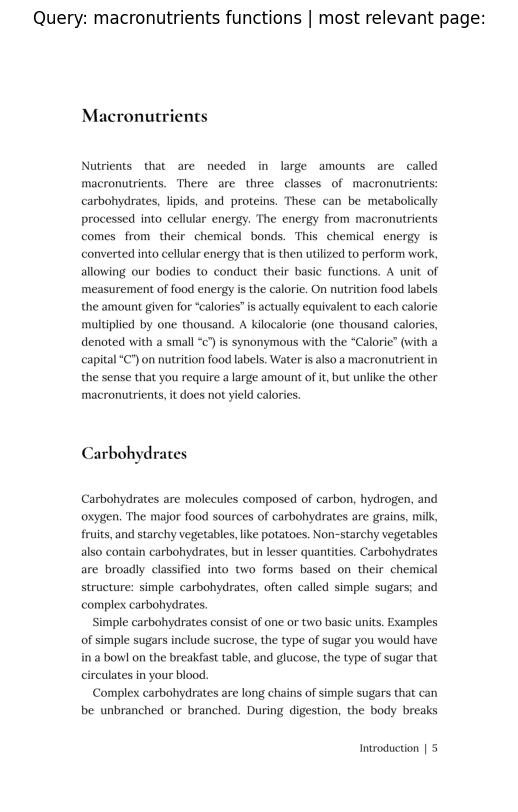

In [35]:
import fitz

pdf_path = "human-nutrition-text.pdf"

doc = fitz.open(pdf_path)
page = doc.load_page(5+41) #added 5 bcoz best page is pagenumber 5

img = page.get_pixmap(dpi = 300)
# img.save("output_filename.png")
doc.close

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h,img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize =(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query} | most relevant page:")
plt.axis('off')
plt.show()


### Similarity measures
TWo ways
1. Dot product
2. Cosine similarity

Cosine similarity eliminates the magnitude and focuses only on direction. \
So Cosine similarity is basically dot product between two unit vectors

In [36]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


## Functionzining the semantic search

In [37]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [38]:
query = "symptoms of pellagra"

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

### Getting an LLM for local Generation

In [39]:
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 12 GB


In [40]:
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 12 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


To load model locally we need a quantization config

In [41]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 

model_id = "google/gemma-2-2b-it"
# model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"

from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)


if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

model_id = model_id 
print(f"[INFO] Using model_id: {model_id}")


tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [42]:
!nvidia-smi

Mon Sep 30 10:30:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| 49%   58C    P2             122W / 350W |   6867MiB / 12288MiB |     30%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [43]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2614341888

In [44]:
def get_model_mem_size(model: torch.nn.Module):
    mem_params = sum([param.nelement()* param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])

    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes /(1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return{
        "model_mem_bytes": model_mem_bytes,
        "model_mem_mb":round(model_mem_mb,2),
        "model_mem_gb": round(model_mem_gb,2)
    }

get_model_mem_size(llm_model)

{'model_mem_bytes': 5228697088, 'model_mem_mb': 4986.47, 'model_mem_gb': 4.87}

### Generating text with our LLM

Using instruction tuned model use chat template, also is the best way to use it

In [45]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [46]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) 
print(f"Model output (tokens):\n{outputs[0]}\n")

The 'max_batch_size' argument of HybridCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.


Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}



Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
          1620,  97586, 184592, 235292,    714,  12980,  61313,    576,   3883,
         14427,    109,  12298,   1695, 184592,    708,    573,  37132,    861,
          2971,   4026,    575,   2910,  15992,    577,   1411,  10338, 235265,
          2365,   3658,   4134, 235269,   2676,   5115,    578,   3505, 235269,
           578,   1707,  41748,   4282,  55786,   9756, 235265, 235248,    109,
          4858, 235303, 235256,    476,  25497,    576,    573,   2149,   1872,
        186809, 184592, 235292,    109,    688, 235274, 235265, 110165,  56227,
         66058,    109, 235287,   5231,  11071,  66058,    714,   7920,   4303,
           576,   4134,    604,    861,   2971, 235265,   2365,    708,  10127,
          1706,  

In [47]:
## decode the output
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
## Macronutrients: The Building Blocks of Your Body

Macronutrients are the nutrients your body needs in large amounts to function properly. They provide energy, support growth and development, and help regulate various bodily processes. 

Here's a breakdown of the three main macronutrients:

**1. Carbohydrates:**

* **Role:** The primary source of energy for your body. They are broken down into glucose, which fuels your cells, brain, and muscles.
* **Types:**
    * **Simple carbohydrates:** Found in sugars like glucose, fructose, and lactose. They are quickly absorbed into the bloodstream, providing a quick burst of energy. Examples include fruits, honey, and processed foods.
    * **Complex carbohydrates:** Found in starches and fiber. They are digested more slowly, providing sustained energy release. Examples include whol

In [48]:
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]


manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [49]:
import random

query = random.choice(query_list)
print(f"Query:- {query}")

scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

Query:- What is the RDI for protein per day?
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.


### Augmenting our prompt with context items

In [52]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])


    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""


    base_prompt = base_prompt.format(context=context, query=query)

    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]


    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [53]:
query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitam

In [54]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")


outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Explain the concept of energy balance and its importance in weight management.
RAG answer:
<bos>Energy balance is the state where energy intake equals energy expenditure. This means that the amount of calories consumed through food and beverages matches the amount of energy used by the body for activities like breathing, digestion, and physical movement. When you are in a positive energy balance, you consume more calories than you burn, leading to weight gain. Conversely, when you are in a negative energy balance, you burn more calories than you consume, resulting in weight loss. Weight, as a measure of energy balance, is maintained when your intake equals your expenditure.

Understanding energy balance is crucial for weight management because it helps individuals understand how their body's energy requirements contribute to weight fluctuations. It's important to note that factors like the timing and composition of meals, sleep patterns, stress levels, and activity levels can al

In [56]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    

    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() 
        

    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")


    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:

        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [57]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What are symptoms of pellagra?
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
Answer:

The symptoms of pellagra are fatigue, decreased appetite, and indigestion. These
symptoms are then commonly followed by the four D’s: diarrhea, dermatitis,
dementia, and sometimes death.  <end_of_turn>
Context items:


[{'page_number': 565,
  'sentence_chunk': 'Niacin deficiency is commonly known as pellagra and the symptoms include fatigue, decreased appetite, and indigestion. \xa0These symptoms are then commonly followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death. Figure 9.12 \xa0Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565',
  'chunk_char_count': 308,
  'chunk_word_count': 43,
  'chunk_token_count': 77.0,
  'embedding': array([ 2.01436728e-02,  8.51663016e-03,  3.45250368e-02,  3.82414237e-02,
          6.64332435e-02,  3.54783908e-02, -4.80622239e-02,  4.61080298e-03,
          3.34795564e-04,  1.60651635e-02,  3.92620489e-02,  6.21891767e-02,
         -1.17300386e-02, -5.21841906e-02,  2.41388734e-02,  5.63627146e-02,
         -1.34784402e-02,  3.53666302e-03,  2.67130341e-02,  2.86840666e-02,
         -1.54798040e-02,  1.54494187e-02,  1.49387242e-02, -1.47909876e-02,
         -3.16866972e-02, -4.39014100e-02,  1.52432248e-02,  1.12245837e-03,
      